In [1]:
%matplotlib inline
from google.cloud import storage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import pandas as pd
import numpy as np

In [2]:
bucket_name = 'catflap-photos-raw'
date = '2020-05-11'

In [3]:
# Set up bucket

client = storage.Client()
bucket = client.get_bucket(bucket_name)

In [5]:
# Get list of blob names

blobs = bucket.list_blobs(prefix=date)
blob_list = [blob.name for blob in blobs]

In [6]:
# Create dataframe of blob names

blob_df = pd.DataFrame()
blob_df['name'] = pd.Series(blob_list)

print(blob_df.shape)
blob_df.head()

(5471, 1)


,name
0,2020-05-11_080042.jpg
1,2020-05-11_080050.jpg
2,2020-05-11_080058.jpg
3,2020-05-11_080105.jpg
4,2020-05-11_080112.jpg


In [7]:
# Create pandas timestamp from blob names

blob_df['timestamp'] = pd.to_datetime(blob_df.name, format='%Y-%m-%d_%H%M%S.jpg')

blob_df.head()

,name,timestamp
0,2020-05-11_080042.jpg,2020-05-11 08:00:42
1,2020-05-11_080050.jpg,2020-05-11 08:00:50
2,2020-05-11_080058.jpg,2020-05-11 08:00:58
3,2020-05-11_080105.jpg,2020-05-11 08:01:05
4,2020-05-11_080112.jpg,2020-05-11 08:01:12


Text(0, 0.5, 'Photos per hour')

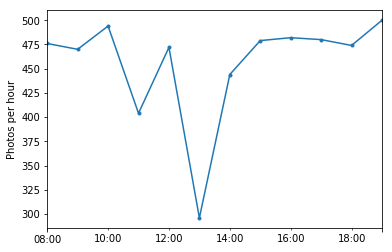

In [8]:
# Plot photos per hour

blob_df.groupby(pd.Grouper(freq='H', key='timestamp')).name.count().plot(style='.-')

plt.xlabel('')
plt.ylabel('Photos per hour')

In [9]:
# Calculate stats for a subset of images

avg_image = None
last_image = None
blob_stats_list = []
for idx, blob_name in enumerate(blob_df.name):
    
    # Print progress every 100 objects
    if idx%100==0:
        print(blob_name)
    
    # Read blob bytes into memory from GCS bucket
    #blob = bucket.blob(blob_name)
    #blob_str = blob.download_as_string()
    #bytes_io = io.BytesIO(blob_str)
    #img = mpimg.imread(bytes_io, format='jpg')
    
    # Read image into memory from disk
    # requires: gsutil -m cp gs://catflap-photos-raw/2020-05-11_* .
    img = mpimg.imread('/home/jupyter/'+date+'/'+blob_name)
    
    blob_stats = {}
    
    # Colours
    mean_colours = np.mean(img, axis=(0,1))
    blob_stats['red'] = mean_colours[0]
    blob_stats['green'] = mean_colours[1]
    blob_stats['blue'] = mean_colours[2]
    
    # Frame diff
    frame_diff = np.nan
    if last_image is not None:
        frame_diff = np.sum(np.abs(img-last_image))
    blob_stats['frame_diff'] = frame_diff
    
    # Update average image by exponential smoothing
    alpha = .3
    if avg_image is None:
        avg_image = img.copy()
    else:
        avg_image = ((alpha*img) + ((1-alpha)*avg_image))
    
    # Average diff
    avg_diff = np.sum(np.abs(img-avg_image))
    blob_stats['avg_diff'] = avg_diff
    
    # Average diff
    std_diff = np.std(img-avg_image)
    blob_stats['std_diff'] = std_diff
    
    blob_stats_list += [blob_stats]
    last_image = img.copy()
    
blob_stats_df = pd.DataFrame(blob_stats_list)

print(blob_stats_df.shape)
blob_stats_df.head()

2020-05-11_080042.jpg
2020-05-11_081325.jpg
2020-05-11_082538.jpg
2020-05-11_083759.jpg
2020-05-11_085101.jpg
2020-05-11_090331.jpg
2020-05-11_091536.jpg
2020-05-11_092739.jpg
2020-05-11_094224.jpg
2020-05-11_095432.jpg
2020-05-11_100706.jpg
2020-05-11_101900.jpg
2020-05-11_103107.jpg
2020-05-11_104313.jpg
2020-05-11_105513.jpg
2020-05-11_110956.jpg
2020-05-11_112333.jpg
2020-05-11_113958.jpg
2020-05-11_115433.jpg
2020-05-11_120725.jpg
2020-05-11_122000.jpg
2020-05-11_123301.jpg
2020-05-11_124527.jpg
2020-05-11_125801.jpg
2020-05-11_131058.jpg
2020-05-11_132506.jpg
2020-05-11_135834.jpg
2020-05-11_141640.jpg
2020-05-11_142857.jpg
2020-05-11_144100.jpg
2020-05-11_145311.jpg
2020-05-11_150532.jpg
2020-05-11_151900.jpg
2020-05-11_153113.jpg
2020-05-11_154332.jpg
2020-05-11_155545.jpg
2020-05-11_160756.jpg
2020-05-11_162052.jpg
2020-05-11_163314.jpg
2020-05-11_164532.jpg
2020-05-11_165755.jpg
2020-05-11_171002.jpg
2020-05-11_172249.jpg
2020-05-11_173533.jpg
2020-05-11_174754.jpg
2020-05-11

,avg_diff,blue,frame_diff,green,red,std_diff
0,0.000,108.520094,NaN,112.864231,110.541225,0.000000
1,2606963.800,108.161006,154371304.0,113.799054,110.052906,2.912030
2,3243946.720,105.609756,247801235.0,111.703946,108.803038,2.937415
3,2799172.922,104.635133,171033336.0,110.806521,109.340135,2.401254
4,2307115.475,105.225069,151387220.0,110.570821,109.130075,2.133146


Text(0.5, 1.0, '2020-05-11_195956.jpg')

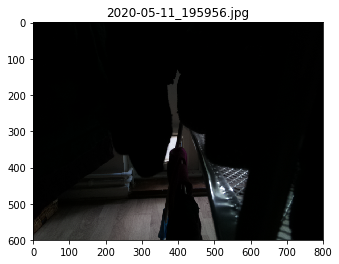

In [10]:
# Plot final exponentially smoothed image

plt.figure()
plt.imshow(avg_image.astype(int))
plt.title(blob_name)

In [11]:
# Join blob names and stats together

stats_df = blob_df.merge(blob_stats_df, right_index=True, left_index=True)

print(stats_df.shape)
stats_df.head()

(5471, 8)


,name,timestamp,avg_diff,blue,frame_diff,green,red,std_diff
0,2020-05-11_080042.jpg,2020-05-11 08:00:42,0.000,108.520094,NaN,112.864231,110.541225,0.000000
1,2020-05-11_080050.jpg,2020-05-11 08:00:50,2606963.800,108.161006,154371304.0,113.799054,110.052906,2.912030
2,2020-05-11_080058.jpg,2020-05-11 08:00:58,3243946.720,105.609756,247801235.0,111.703946,108.803038,2.937415
3,2020-05-11_080105.jpg,2020-05-11 08:01:05,2799172.922,104.635133,171033336.0,110.806521,109.340135,2.401254
4,2020-05-11_080112.jpg,2020-05-11 08:01:12,2307115.475,105.225069,151387220.0,110.570821,109.130075,2.133146


Text(0, 0.5, 'Average colour value')

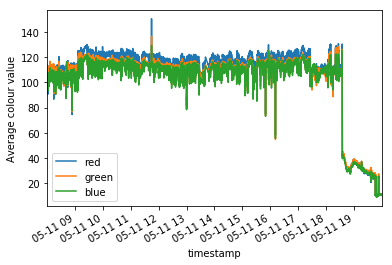

In [19]:
# Plot colour levels over time

colours = ['red','green','blue']
stats_df.set_index('timestamp')[colours].plot()
plt.ylabel('Average colour value')

In [13]:
# Calculate brightness by averaging RGB colours

stats_df['brightness'] = stats_df[colours].mean(axis=1)

stats_df.head()

,name,timestamp,avg_diff,blue,frame_diff,green,red,std_diff,brightness
0,2020-05-11_080042.jpg,2020-05-11 08:00:42,0.000,108.520094,NaN,112.864231,110.541225,0.000000,110.641850
1,2020-05-11_080050.jpg,2020-05-11 08:00:50,2606963.800,108.161006,154371304.0,113.799054,110.052906,2.912030,110.670989
2,2020-05-11_080058.jpg,2020-05-11 08:00:58,3243946.720,105.609756,247801235.0,111.703946,108.803038,2.937415,108.705580
3,2020-05-11_080105.jpg,2020-05-11 08:01:05,2799172.922,104.635133,171033336.0,110.806521,109.340135,2.401254,108.260597
4,2020-05-11_080112.jpg,2020-05-11 08:01:12,2307115.475,105.225069,151387220.0,110.570821,109.130075,2.133146,108.308655


Text(0, 0.5, 'Average difference between consecutive frames')

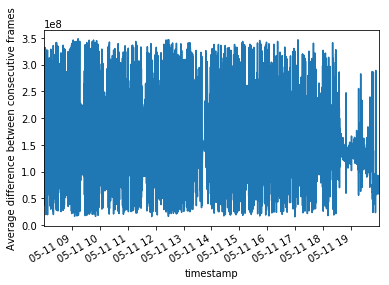

In [20]:
# Plot frame difference over time

stats_df.set_index('timestamp').frame_diff.plot()
plt.ylabel('Average difference between consecutive frames')

Text(0, 0.5, 'Average difference with smoothed image')

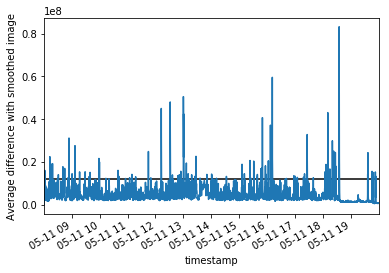

In [21]:
# Plot difference with exponentially smoothed image over time

stats_df.set_index('timestamp').avg_diff.plot()

threshold = 1.2e7
xlim = plt.xlim()
plt.hlines(threshold, xlim[0], xlim[1])

plt.ylabel('Average difference with smoothed image')

Text(0, 0.5, 'Standard deviation of differences with smoothed image')

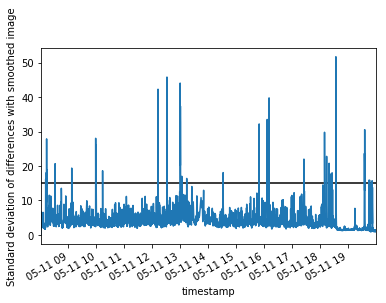

In [22]:
# Plot standard deviation of differences with exponentially smoothed image over time

stats_df.set_index('timestamp').std_diff.plot()

threshold = 15
xlim = plt.xlim()
plt.hlines(threshold, xlim[0], xlim[1])

plt.ylabel('Standard deviation of differences with smoothed image')

In [17]:
# Create dataframe of interesting images

interesting_blobs = stats_df[stats_df.std_diff>threshold]

print(interesting_blobs.shape)

(58, 9)


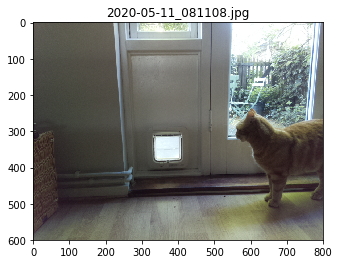

In [18]:
# Plot images

for blob_name in interesting_blobs.name:
    
    blob = bucket.blob(blob_name)
    blob_str = blob.download_as_string()
    bytes_io = io.BytesIO(blob_str)
    img = mpimg.imread(bytes_io, format='jpg')
    plt.figure()
    plt.imshow(img)
    plt.title(blob_name)
    
    break